Mounted at /content/drive/
Found 4236 validated image filenames belonging to 5 classes.
Found 1059 validated image filenames belonging to 5 classes.
473176280/473176280 [==============================] - 3s 0us/step


Epoch 1/20
66/66 [==============================] - 2063s 30s/step - loss: 1.0495 - accuracy: 0.5638 - val_loss: 0.6316 - val_accuracy: 0.7041
Epoch 2/20
66/66 [==============================] - 75s 1s/step - loss: 0.6490 - accuracy: 0.7224 - val_loss: 0.5773 - val_accuracy: 0.7656
Epoch 3/20
66/66 [==============================] - 75s 1s/step - loss: 0.5409 - accuracy: 0.7716 - val_loss: 0.4642 - val_accuracy: 0.8105
Epoch 4/20
66/66 [==============================] - 77s 1s/step - loss: 0.4774 - accuracy: 0.7951 - val_loss: 0.3905 - val_accuracy: 0.7891
Epoch 5/20
66/66 [==============================] - 76s 1s/step - loss: 0.4390 - accuracy: 0.8135 - val_loss: 0.4338 - val_accuracy: 0.8350
Epoch 6/20
66/66 [==============================] - 76s 1s/step - loss: 0.4002 - accuracy: 0.8207 - val_loss: 0.3933 - val_accuracy: 0.8428
Epoch 7/20
66/66 [==============================] - 77s 1s/step - loss: 0.3996 - accuracy: 0.8260 - val_loss: 0.4078 - val_accuracy: 0.7900
Epoch 8/20
66/66 

<ipython-input-1-955d4faeb863>:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)


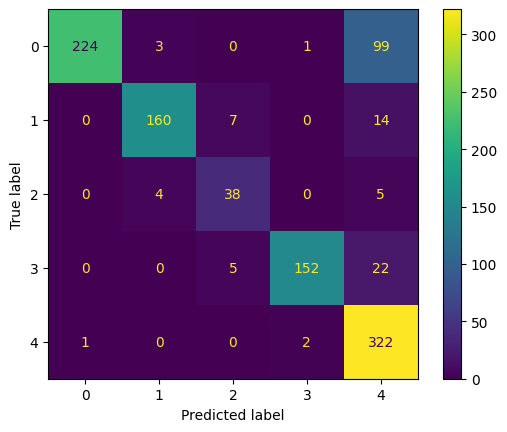

In [ ]:
import pandas as pd
from google.colab import drive
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/results/results_sample_data_2.csv")


df.Class = df.Class.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Image_mask_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Image_mask_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)

base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=4236   //64,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 1059 // 64,
                    callbacks = [callback])

y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)
Y_pred = np.argmax(y_pred, axis=1)


confusion_matrix = confusion_matrix(val_data_generator.classes, Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_data_generator.classes, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.69      0.81       327
           1       0.96      0.88      0.92       181
           2       0.76      0.81      0.78        47
           3       0.98      0.85      0.91       179
           4       0.70      0.99      0.82       325

    accuracy                           0.85      1059
   macro avg       0.88      0.84      0.85      1059
weighted avg       0.88      0.85      0.85      1059



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(val_data_generator.classes, Y_pred)

0.846081208687441